#Load Dataset

In [ ]:
!gdown --id 1wocevn5kbIGTSKR_rkpjeKy_meeG76aF

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1wocevn5kbIGTSKR_rkpjeKy_meeG76aF
From (redirected): https://drive.google.com/uc?id=1wocevn5kbIGTSKR_rkpjeKy_meeG76aF&confirm=t&uuid=133fefc1-6ee5-4044-ab26-5e436b74a786
To: /content/Jackfruit_Augmented_Dataset.zip
100% 459M/459M [00:08<00:00, 53.8MB/s]


In [ ]:
!unzip '/content/Jackfruit_Augmented_Dataset.zip'

Streaming output truncated to the last 5000 lines.
  inflating: Jackfruit_Augmented_Dataset/Aug_Anthracnose/aug_anthracnose_(722).png  
  inflating: Jackfruit_Augmented_Dataset/Aug_Anthracnose/aug_anthracnose_(723).png  
  inflating: Jackfruit_Augmented_Dataset/Aug_Anthracnose/aug_anthracnose_(724).png  
  inflating: Jackfruit_Augmented_Dataset/Aug_Anthracnose/aug_anthracnose_(725).png  
  inflating: Jackfruit_Augmented_Dataset/Aug_Anthracnose/aug_anthracnose_(726).png  
  inflating: Jackfruit_Augmented_Dataset/Aug_Anthracnose/aug_anthracnose_(727).png  
  inflating: Jackfruit_Augmented_Dataset/Aug_Anthracnose/aug_anthracnose_(728).png  
  inflating: Jackfruit_Augmented_Dataset/Aug_Anthracnose/aug_anthracnose_(729).png  
  inflating: Jackfruit_Augmented_Dataset/Aug_Anthracnose/aug_anthracnose_(73).png  
  inflating: Jackfruit_Augmented_Dataset/Aug_Anthracnose/aug_anthracnose_(730).png  
  inflating: Jackfruit_Augmented_Dataset/Aug_Anthracnose/aug_anthracnose_(731).png  
  inflating: Ja

#Data Pre-Process

In [ ]:
from torchvision.datasets import ImageFolder

dataset = ImageFolder('/content/Jackfruit_Augmented_Dataset')
print(dataset.classes)

['Aug_Algal', 'Aug_Anthracnose', 'Aug_Healthy', 'Aug_Leaf Spot', 'Aug_Phyllosticta', 'Aug_Sooty Mold']


In [ ]:
class_names = ['Algal', 'Anthracnose', 'Healthy', 'Leaf Spot', 'Phyllosticta', 'Sooty Mold']

In [ ]:
import tensorflow as tf
import os

def load_image(path):
    """Load images in their original RGB format and resize to 224x224"""
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [224, 224])
    return image

def label_lookup(label_name):
    """Map label name to index"""
    label_names = tf.constant(['Aug_Algal', 'Aug_Anthracnose', 'Aug_Healthy', 'Aug_Leaf Spot', 'Aug_Phyllosticta', 'Aug_Sooty Mold'])
    idx = tf.where(label_names == label_name)[0][0]
    return idx

def get_label(file_path):
    """Parse and one-hot encode the label from the file path, ensuring correct shape"""
    parts = tf.strings.split(file_path, os.path.sep)
    label = parts[-2]
    label_id = label_lookup(label)
    one_hot = tf.one_hot(label_id, depth=6)
    return one_hot

def prepare_dataset(paths, batch_size=32):
    """Prepare a TensorFlow dataset for training or validation"""
    dataset = tf.data.Dataset.from_tensor_slices(paths)
    dataset = dataset.map(lambda x: (load_image(x), get_label(x)), num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.shuffle(buffer_size=1000).batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

In [ ]:
# Load and split the dataset
folder_path = '/content/Jackfruit_Augmented_Dataset'
all_files = tf.io.gfile.glob(os.path.join(folder_path, '*', '*'))
all_files = tf.random.shuffle(all_files)

train_size = int(0.7 * len(all_files))
val_size = int(0.2 * len(all_files))
test_size = len(all_files) - train_size - val_size

train_files = all_files[:train_size]
val_files = all_files[train_size:train_size + val_size]
test_files = all_files[train_size + val_size:]

# Ensure splits are not empty
assert len(train_files) > 0, "Training set is empty"
assert len(val_files) > 0, "Validation set is empty"
assert len(test_files) > 0, "Test set is empty"

train_dataset = prepare_dataset(train_files)
val_dataset = prepare_dataset(val_files)
test_dataset = prepare_dataset(test_files)

# Print shapes of the datasets
for images, labels in train_dataset.take(1):
    print(f'Train images shape: {images.shape}')
    print(f'Train labels shape: {labels.shape}')

for images, labels in val_dataset.take(1):
    print(f'Validation images shape: {images.shape}')
    print(f'Validation labels shape: {labels.shape}')

for images, labels in test_dataset.take(1):
    print(f'Test images shape: {images.shape}')
    print(f'Test labels shape: {labels.shape}')

print(f'Number of training images: {len(train_files)}')
print(f'Number of validation images: {len(val_files)}')
print(f'Number of test images: {len(test_files)}')

Train images shape: (32, 224, 224, 3)
Train labels shape: (32, 6)
Validation images shape: (32, 224, 224, 3)
Validation labels shape: (32, 6)
Test images shape: (32, 224, 224, 3)
Test labels shape: (32, 6)
Number of training images: 4901
Number of validation images: 1400
Number of test images: 701


#**Model:** ResNet152

In [ ]:
from tensorflow.keras.applications import ResNet152
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
import os

In [ ]:
# Load the ResNet152 model without the top layer:
base_model = ResNet152(input_shape=(224,224,3), include_top=False, weights='imagenet')

# Freeze the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

# Create a Sequential model
x = base_model.output
x = Dropout(0.5)(x)  # Add a dropout layer
x = GlobalAveragePooling2D()(x)
predictions = Dense(6, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model:
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

import time

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

# Start the timer
start_time = time.time()

# Train the model
history = model.fit(train_dataset, validation_data=val_dataset, epochs=50, callbacks=[early_stopping])

# End the timer
end_time = time.time()

# Calculate and print the training duration
training_duration = end_time - start_time
print(f"Training completed in: {training_duration:.2f} seconds")

234698864/234698864 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 103s 455ms/step - accuracy: 0.5627 - loss: 1.1431 - val_accuracy: 0.7814 - val_loss: 0.5905
Epoch 2/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 50s 315ms/step - accuracy: 0.8209 - loss: 0.5077 - val_accuracy: 0.8321 - val_loss: 0.4416
Epoch 3/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 49s 304ms/step - accuracy: 0.8694 - loss: 0.3915 - val_accuracy: 0.8757 - val_loss: 0.3819
Epoch 4/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 49s 307ms/step - accuracy: 0.8803 - loss: 0.3503 - val_accuracy: 0.8814 - val_loss: 0.3376
Epoch 5/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 50s 310ms/step - accuracy: 0.8996 - loss: 0.2899 - val_accuracy: 0.8964 - val_loss: 0.3132
Epoch 6/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 83s 315ms/step - accuracy: 0.9109 - loss: 0.2635 - val_accuracy: 0.8957 - val_loss: 0.2954
Epoch 7/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 90s 367ms/step - accuracy: 0.9095 - loss: 0.2494 - val_accuracy: 0.8957 - val_loss: 0.2841
Epoch 8/50
154/154 ━━━━━━━━━━

In [ ]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from tensorflow.keras.utils import to_categorical


def dataset_to_numpy_arrays(dataset):
    all_images = []
    all_labels = []
    for images, labels in dataset.unbatch().batch(1).as_numpy_iterator():
        all_images.append(images[0])
        all_labels.append(np.argmax(labels[0]))  # Assuming labels are one-hot encoded
    return np.array(all_images), np.array(all_labels)

# Predict on test set
test_images, test_true_labels = dataset_to_numpy_arrays(test_dataset)
test_pred_probs = model.predict(test_images)
test_pred_labels = np.argmax(test_pred_probs, axis=1)

# Calculate precision, recall, and F1-score using sklearn
precision = precision_score(test_true_labels, test_pred_labels, average='macro')
recall = recall_score(test_true_labels, test_pred_labels, average='macro')
f1 = f1_score(test_true_labels, test_pred_labels, average='macro')

# Test code to evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")


print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")

22/22 ━━━━━━━━━━━━━━━━━━━━ 28s 810ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 10s 393ms/step - accuracy: 0.9130 - loss: 0.2054
Test Loss: 0.21018707752227783, Test Accuracy: 0.9144079685211182
Precision: 0.9170636926022057
Recall: 0.9108286252354049
F1-Score: 0.9125847769309575


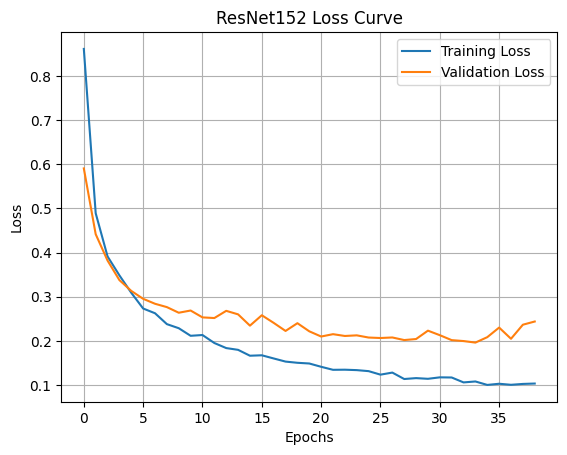

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('ResNet152 Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

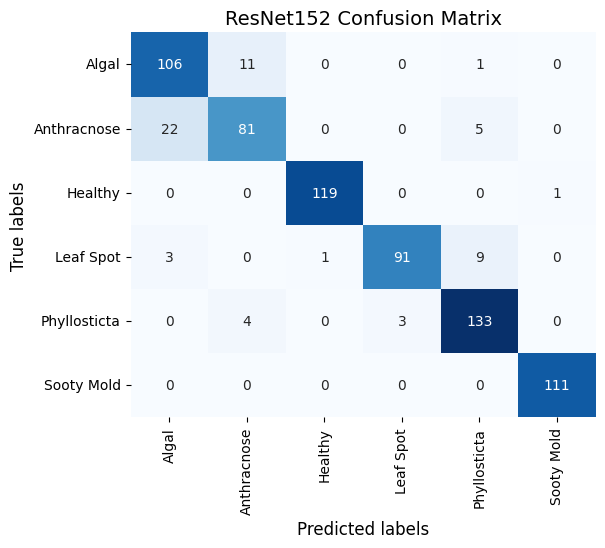

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Generate confusion matrix
conf_matrix = confusion_matrix(test_true_labels, test_pred_labels)

# Plot confusion matrix
plt.figure(figsize=(6, 5))  # Decreased the figure size
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=class_names, yticklabels=class_names, annot_kws={"size": 10})  # Set annot font size
plt.xlabel('Predicted labels', fontsize=12)  # Increased font size
plt.ylabel('True labels', fontsize=12)  # Increased font size
plt.title('ResNet152 Confusion Matrix', fontsize=14)  # Increased title font size
plt.xticks(fontsize=10)  # Adjust font size for x-ticks
plt.yticks(fontsize=10)  # Adjust font size for y-ticks
plt.show()

In [ ]:
# Save the model in HDF5 format
model.save('jackfruit_ResNet152_model.h5')

In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 58,407,828 (222.81 MB)

 Trainable params: 12,294 (48.02 KB)

 Non-trainable params: 58,370,944 (222.67 MB)

 Optimizer params: 24,590 (96.06 KB)

#**Model:** MobileNet V2

In [ ]:
from keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
import os

In [ ]:
# Load the MobileNetV2 model without the top layer:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

# Create a Sequential model
x = base_model.output
x = Dense(64, activation='relu')(x)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)  # Add a dropout layer
predictions = Dense(6, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model:
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

import time

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

# Start the timer
start_time = time.time()

# Train the model
history = model.fit(train_dataset, validation_data=val_dataset, epochs=50, callbacks=[early_stopping])

# End the timer
end_time = time.time()

# Calculate and print the training duration
training_duration = end_time - start_time
print(f"Training completed in: {training_duration:.2f} seconds")

Epoch 1/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 39s 171ms/step - accuracy: 0.3299 - loss: 1.6936 - val_accuracy: 0.5443 - val_loss: 1.1660
Epoch 2/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 17s 101ms/step - accuracy: 0.5116 - loss: 1.2170 - val_accuracy: 0.6143 - val_loss: 1.0252
Epoch 3/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 20s 93ms/step - accuracy: 0.5666 - loss: 1.0614 - val_accuracy: 0.6421 - val_loss: 0.9426
Epoch 4/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 20s 89ms/step - accuracy: 0.6079 - loss: 0.9811 - val_accuracy: 0.6586 - val_loss: 0.8856
Epoch 5/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 16s 92ms/step - accuracy: 0.6418 - loss: 0.9031 - val_accuracy: 0.6514 - val_loss: 0.8894
Epoch 6/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 16s 93ms/step - accuracy: 0.6500 - loss: 0.8737 - val_accuracy: 0.6536 - val_loss: 0.8288
Epoch 7/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 20s 92ms/step - accuracy: 0.6626 - loss: 0.8151 - val_accuracy: 0.6886 - val_loss: 0.7996
Epoch 8/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 19s 110ms/step - accuracy: 0.6843 - loss: 0.7946

In [ ]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from tensorflow.keras.utils import to_categorical


def dataset_to_numpy_arrays(dataset):
    all_images = []
    all_labels = []
    for images, labels in dataset.unbatch().batch(1).as_numpy_iterator():
        all_images.append(images[0])
        all_labels.append(np.argmax(labels[0]))  # Assuming labels are one-hot encoded
    return np.array(all_images), np.array(all_labels)

# Predict on test set
test_images, test_true_labels = dataset_to_numpy_arrays(test_dataset)
test_pred_probs = model.predict(test_images)
test_pred_labels = np.argmax(test_pred_probs, axis=1)

# Calculate precision, recall, and F1-score using sklearn
precision = precision_score(test_true_labels, test_pred_labels, average='macro')
recall = recall_score(test_true_labels, test_pred_labels, average='macro')
f1 = f1_score(test_true_labels, test_pred_labels, average='macro')

# Test code to evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")


print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")

22/22 ━━━━━━━━━━━━━━━━━━━━ 11s 272ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 0.7554 - loss: 0.6384
Test Loss: 0.6586188077926636, Test Accuracy: 0.7432239651679993
Precision: 0.7486026159217712
Recall: 0.7409760182359052
F1-Score: 0.742107600616594


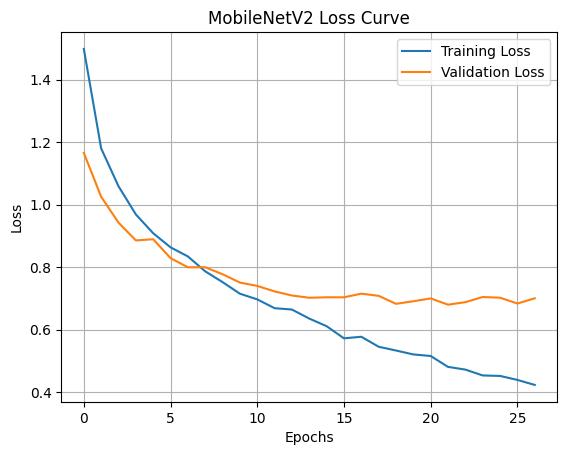

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('MobileNetV2 Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

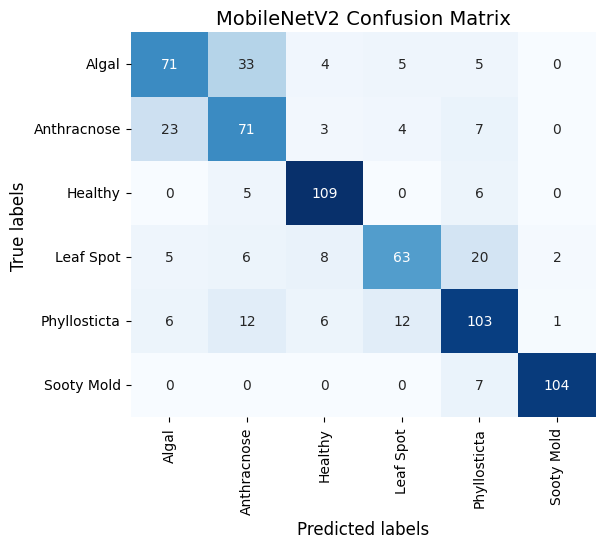

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Generate confusion matrix
conf_matrix = confusion_matrix(test_true_labels, test_pred_labels)

# Plot confusion matrix
plt.figure(figsize=(6, 5))  # Decreased the figure size
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=class_names, yticklabels=class_names, annot_kws={"size": 10})  # Set annot font size
plt.xlabel('Predicted labels', fontsize=12)  # Increased font size
plt.ylabel('True labels', fontsize=12)  # Increased font size
plt.title('MobileNetV2 Confusion Matrix', fontsize=14)  # Increased title font size
plt.xticks(fontsize=10)  # Adjust font size for x-ticks
plt.yticks(fontsize=10)  # Adjust font size for y-ticks
plt.show()

In [ ]:
# Save the model in HDF5 format
model.save('jackfruit_MobileNetV2_model.h5')

In [ ]:
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,505,108 (9.56 MB)

 Trainable params: 82,374 (321.77 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

 Optimizer params: 164,750 (643.56 KB)